## Curve of Growth with GAaP

For point-sources, one would expect that having a wider aperture must lead to a slightly larger flux on average, and certainly not a lower value of flux systematically. However, GAaP fluxes for PSF stars exhibit this counter intuitive behaviour.

In [1]:
import numpy as np
from imp import reload

import matplotlib
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor':"w"}
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import galsim

from lsst.daf.butler import Butler
import lsst.afw.detection as afwDetection
import lsst.afw.geom as afwGeom
from lsst.meas.base import SdssShapeAlgorithm, SafeCentroidExtractor
import lsst.meas.extensions.gaap

In [85]:
reload(lsst.meas.extensions.gaap)

<module 'lsst.meas.extensions.gaap' from '/home/kannawad/repo/meas_extensions_gaap/python/lsst/meas/extensions/gaap/__init__.py'>

In [2]:
matplotlib.rcParams['ps.useafm']=True
matplotlib.rcParams['pdf.use14corefonts']=True
matplotlib.rcParams['text.usetex']=True
matplotlib.rcParams['ps.useafm']=True
matplotlib.rcParams['pdf.use14corefonts']=True
matplotlib.rcParams['text.usetex']=True
matplotlib.rcParams['legend.fontsize']=14
matplotlib.rcParams['legend.numpoints']=1
matplotlib.rcParams['legend.frameon']=False
matplotlib.rcParams['legend.handlelength']=0.
matplotlib.rcParams['xtick.minor.visible']=True
matplotlib.rcParams['ytick.minor.visible']=True
matplotlib.rcParams['ytick.direction']='inout'
matplotlib.rcParams['xtick.direction']='inout'
if matplotlib.rcParams['xtick.direction']=='inout':
    matplotlib.rcParams['xtick.major.size']=2.*matplotlib.rcParams['xtick.major.size']
    matplotlib.rcParams['xtick.minor.size']=2.*matplotlib.rcParams['xtick.minor.size']
if matplotlib.rcParams['ytick.direction']=='inout':
    matplotlib.rcParams['ytick.major.size']=2.*matplotlib.rcParams['ytick.major.size']
    matplotlib.rcParams['ytick.minor.size']=2.*matplotlib.rcParams['ytick.minor.size']
matplotlib.rcParams['figure.subplot.bottom']=0.1
matplotlib.rcParams['figure.subplot.top']=0.95
matplotlib.rcParams['figure.subplot.right']=0.95
matplotlib.rcParams['figure.subplot.left']=0.095
matplotlib.rcParams['axes.labelsize']=18
matplotlib.rc('font',size=18)

In [85]:
REPO="/project/hsc/gen3repo/rc2w06_ssw06"
collection="u/kannawad/gaap1"

butler = Butler(REPO, run=collection)

In [4]:
dataId = {'tract': 9615, 'patch':23, 'band':'i'}

In [5]:
meas = butler.get("deepCoadd_meas", **dataId)
deepCoadd = butler.get("deepCoadd_calexp", **dataId)
photoCalib = deepCoadd.getPhotoCalib()

In [6]:
psfStars = meas['calib_psf_used']

<ipython-input-7-ecf76e805b1b>:3: RuntimeWarning: invalid value encountered in log10
  logFluxRatio = -2.5*np.log10(fluxRatio)


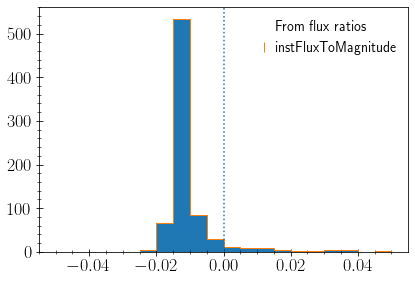

In [7]:
bins = np.linspace(-0.05, 0.05, 21)
fluxRatio = meas['ext_gaap_GaapFlux_1_15x_4_0_instFlux']/meas['ext_gaap_GaapFlux_1_15x_5_0_instFlux']
logFluxRatio = -2.5*np.log10(fluxRatio)
magDiff = photoCalib.instFluxToMagnitude(meas, 'ext_gaap_GaapFlux_1_15x_4_0')[:,0]-photoCalib.instFluxToMagnitude(meas, 'ext_gaap_GaapFlux_1_15x_5_0')[:,0]
plt.hist(logFluxRatio[psfStars], bins=bins, histtype='stepfilled',label='From flux ratios')
plt.hist(magDiff[psfStars], bins=bins, histtype='step', label='instFluxToMagnitude')
plt.axvline(0.0, ls=':')
plt.legend()

Thus, the flux photometered with $\sigma=4$ pixels is systematically larger than the flux photometered with $\sigma=5$ pixel Gaussian.

### Prime suspects

1. #### Normalization issues in the Gaussian aperture ####
3. #### Photometric calibration differences: ####

    Because this is in the same band, the photometric calibration should not matter. Additionally, it is present in the ratio of instFlux as well as difference of magnitudes.
2. #### Gaussianized PSF has negative pixel rings ####

In [8]:
## Initialize the GAaP measurement plugin
gaapConfig = lsst.meas.extensions.gaap.GaapFluxConfig()
gaapPlugin = lsst.meas.extensions.gaap.GaapFluxPlugin(gaapConfig, 'ext_testGaap_GaapFlux', meas.schema, None)

In [9]:
record = meas[psfStars][110]
bbox = record.getFootprint().getBBox()
center = lsst.geom.Point2D(record['base_SdssShape_x'], record['base_SdssShape_y'])
seeing = deepCoadd.getPsf().computeShape(center).getTraceRadius()
targetSigma = 1.15*seeing
stampSize = gaapConfig.modelPsfDimension
targetPsf = afwDetection.GaussianPsf(stampSize, stampSize, targetSigma)

In [10]:
record['ext_gaap_GaapFlux_flag_edge'], center, bbox

(False,
 Point2D(20985.4499, 9220.344379),
 Box2I(minimum=Point2I(20967, 9199), dimensions=Extent2I(40, 52)))

In [11]:
record['ext_gaap_GaapFlux_1_15x_4_0_instFlux'], record['ext_gaap_GaapFlux_1_15x_5_0_instFlux']

(3347.7318494582773, 3306.1418332979956)

In [12]:
convolved = gaapPlugin._generic.convolve(deepCoadd, targetPsf, record)

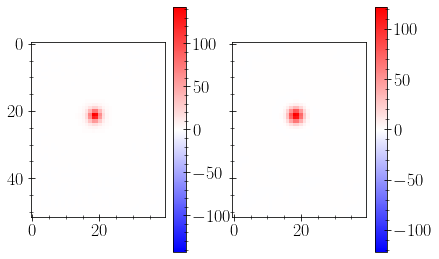

In [13]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)

vmax = max(-deepCoadd[bbox].image.array.min(), deepCoadd[bbox].image.array.max())
_im = ax[0].imshow(deepCoadd[bbox].image.array, cmap=cm.bwr, vmin=-vmax, vmax=vmax)
fig.colorbar(_im, ax=ax[0])

vmax = max(-convolved.getMaskedImage().image.array.min(), convolved.getMaskedImage().image.array.max())
_im = ax[1].imshow(convolved.getMaskedImage().image.array, cmap=cm.bwr, vmin=-vmax, vmax=vmax)
fig.colorbar(_im, ax=ax[1])

In [14]:
print("Observed peak = ", convolved.getMaskedImage().image.array.max())
flux = record['base_PsfFlux_instFlux']
print(f"{flux*np.exp(-1.0*(0.5/targetSigma)**2)/(2*np.pi*targetSigma**2)} < Exepected peak < {flux/(2*np.pi*targetSigma**2)}")

Observed peak =  121.684105
116.57416381640033 < Exepected peak < 131.2088156101875


In [15]:
origPsf = galsim.Image(deepCoadd[bbox].image.array)
newPsf = galsim.Image(convolved.getMaskedImage().image.array)
print(origPsf.FindAdaptiveMom().moments_centroid, newPsf.FindAdaptiveMom().moments_centroid)

galsim.PositionD(19.449951609743,22.34279573910298) galsim.PositionD(19.449385130128917,22.345023600854894)


In [16]:
sigma = 1.4/3
targetPsf = galsim.Gaussian(sigma=sigma, flux=1000.)
targetPsfIm = galsim.Image(64,64)
targetPsfIm = targetPsf.drawImage(image=targetPsfIm, scale=1.0, method='auto')
weight = galsim.Gaussian(sigma=sigma, flux=2.*np.pi*sigma**2)
weightIm = galsim.Image(64,64)
weightIm = weight.drawImage(image=weightIm, scale=1.0, method='no_pixel')

print(np.sum(weightIm.array*targetPsfIm.array)*2.0, np.sum(weightIm.array**2))

594.819580078125 0.40275833


In [17]:
targetPsfIm.array.sum(), weightIm.array.sum()/(2*np.pi*sigma**2)

(999.99677, 0.946396848420875)

In [18]:
convolved.getMaskedImage().getBBox(), bbox

(Box2I(minimum=Point2I(20967, 9199), dimensions=Extent2I(40, 52)),
 Box2I(minimum=Point2I(20967, 9199), dimensions=Extent2I(40, 52)))

In [19]:
for sigma in gaapConfig.sigmas:
    aperSigma2 = sigma**2 - targetSigma**2
    aperShape = afwGeom.Quadrupole(aperSigma2, aperSigma2, 0.0)
    fluxResult = SdssShapeAlgorithm.computeFixedMomentsFlux(convolved.getMaskedImage(),
                                                            aperShape, center)
    fluxScaling = sigma**2/aperSigma2
    print(fluxResult.instFlux, fluxResult.instFlux*fluxScaling, fluxScaling)

2998.6771337896917 3455.1806280400174 1.1522349602450872
3163.9280549304294 3456.174315181263 1.092368174995452


In [20]:
clippedImage = convolved.getMaskedImage()
clippedImage.image.array[clippedImage.image.array<0]=0

In [21]:
for sigma in gaapConfig.sigmas:
    aperSigma2 = sigma**2 - targetSigma**2
    aperShape = afwGeom.Quadrupole(aperSigma2, aperSigma2, 0.0)
    fluxResult = SdssShapeAlgorithm.computeFixedMomentsFlux(clippedImage,
                                                            aperShape, center)
    fluxScaling = sigma**2/aperSigma2
    print(fluxResult.instFlux, fluxResult.instFlux*fluxScaling, fluxScaling)

3000.8094212393153 3457.6375241847654 1.1522349602450872
3167.547735399915 3460.128338929782 1.092368174995452


#### Would PSF photometry have given some clue?

In [23]:
print(record['base_PsfFlux_instFlux'])
aperSigma2 = targetSigma**2
aperShape = afwGeom.Quadrupole(aperSigma2, aperSigma2, 0.0)
fluxResult = SdssShapeAlgorithm.computeFixedMomentsFlux(convolved.getMaskedImage(),
                                                        aperShape, center)
fluxScaling = 1. ## should be 2 but this is done in computeFixedMomentsFlux
print(fluxResult.instFlux*fluxScaling, convolved.getMaskedImage().image.array.sum(), deepCoadd[bbox].image.array.sum())
print(np.sqrt(np.sum(convolved.getMaskedImage().image.array**2)))

1742.7545139166486
1737.1434383062733 1790.043 1781.3506
337.0568


In [26]:
bbox.erodedBy(gaapConfig.modelPsfMatch.kernel.active.kernelSize//2)

Box2I(minimum=Point2I(20967, 9199), dimensions=Extent2I(40, 52))

In [25]:
gaapPlugin._generic.measure?

#### Let us measure for all sources

In [39]:
(psfStars&(meas['ext_gaap_GaapFlux_flag']==0)).sum()

771

In [31]:
gaapPsfPhot, gaap4, gaap5 = [], [], []
for record in meas[psfStars&(meas['ext_gaap_GaapFlux_flag']==0)]:
    bbox = record.getFootprint().getBBox()
    center = lsst.geom.Point2D(record['base_SdssShape_x'], record['base_SdssShape_y'])
    seeing = deepCoadd.getPsf().computeShape(center).getTraceRadius()
    targetSigma = 1.15*seeing
    stampSize = gaapConfig.modelPsfDimension
    targetPsf = afwDetection.GaussianPsf(stampSize, stampSize, targetSigma)
    
    convolved = gaapPlugin._generic.convolve(deepCoadd, targetPsf, record)
    
    ## PSF photometry
    aperSigma2 = targetSigma**2
    aperShape = afwGeom.Quadrupole(aperSigma2, aperSigma2, 0.0)
    fluxResult = SdssShapeAlgorithm.computeFixedMomentsFlux(convolved.getMaskedImage(),
                                                            aperShape, center)
    fluxScaling = 1. ## should be 2 but this is done in computeFixedMomentsFlux
    gaapPsfPhot.append( fluxResult.instFlux*fluxScaling )
    ## Aperture photometry
    for sigma in gaapConfig.sigmas:
        aperSigma2 = sigma**2 - targetSigma**2
        aperShape = afwGeom.Quadrupole(aperSigma2, aperSigma2, 0.0)
        fluxResult = SdssShapeAlgorithm.computeFixedMomentsFlux(convolved.getMaskedImage(),
                                                                aperShape, center)
        fluxScaling = 0.5*sigma**2/aperSigma2
        
        if sigma==4:
            gaap4.append( fluxResult.instFlux*fluxScaling)
        elif sigma==5:
            gaap5.append( fluxResult.instFlux*fluxScaling)
            

Text(0.5, 0, '$\\Delta$ PSF magnitude')

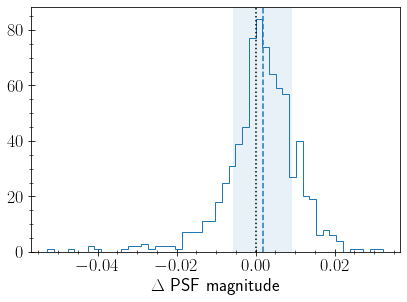

In [64]:
fig, ax = plt.subplots()
fluxRatio = np.array(gaapPsfPhot)/X
dmag = -2.5*np.log10(fluxRatio)
bins = 50
ax.hist(dmag, bins=bins, histtype='step')
ax.axvspan(xmin=np.percentile(dmag, 16), xmax=np.percentile(dmag,84),alpha=0.1)
ax.axvline(np.percentile(dmag,50), color='C0', ls='--')
ax.axvline(0.0, color='k', ls=':')
ax.set_xlabel(r'$\Delta$ PSF magnitude')

Text(0, 0.5, 'GAaP PSF instFlux / PSF instFlux')

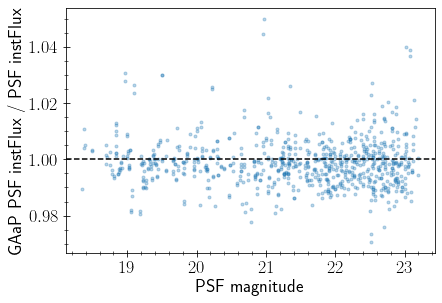

In [66]:
fig, ax = plt.subplots()
X = meas[psfStars&(meas['ext_gaap_GaapFlux_flag']==0)]['base_PsfFlux_instFlux']
fluxRatio = np.array(gaapPsfPhot)/X
psfMag = photoCalib.instFluxToMagnitude(meas[psfStars&(meas['ext_gaap_GaapFlux_flag']==0)],'base_PsfFlux')[:,0]
ax.plot(psfMag, fluxRatio, '.', alpha=0.3)

#cat = meas[psfStars&(meas['ext_gaap_GaapFlux_flag']==0)]
#trRadius = np.sqrt(0.5*(cat['base_SdssShape_xx']+cat['base_SdssShape_yy']))

#ax[1].plot(trRadius, fluxRatio, '.', alpha=0.3)
ax.axhline(1.0, color='k', ls='--')
ax.set_xlabel('PSF magnitude')
ax.set_ylabel('GAaP PSF instFlux / PSF instFlux')

Text(0.5, 0, 'PSF magnitude')

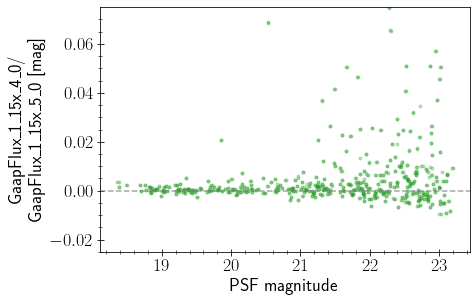

In [63]:
fig, ax = plt.subplots(1)
X = meas[psfStars&(meas['ext_gaap_GaapFlux_flag']==0)]['base_PsfFlux_instFlux']
fluxRatio = np.array(gaap4)/np.array(gaap5)
psfMag = photoCalib.instFluxToMagnitude(meas[psfStars&(meas['ext_gaap_GaapFlux_flag']==0)],'base_PsfFlux')[:,0]
ax.plot(psfMag, -2.5*np.log10(fluxRatio), '.', color='C2', alpha=0.3)

cat = meas[psfStars&(meas['ext_gaap_GaapFlux_flag']==0)]
trRadius = np.sqrt(0.5*(cat['base_SdssShape_xx']+cat['base_SdssShape_yy']))

#ax.plot(trRadius, -2.5*np.log10(fluxRatio), '.', alpha=0.3)
#ax.axhline(1.0, color='k', ls='--')
#ax.axhline(1.0, color='k', ls='--')

#for _ax in ax:
_ax = ax
ax.axhline(0.0, color='gray', ls='--', alpha=0.7)
ax.set_ylim([-0.025,0.075])
ax.set_ylabel("GaapFlux\_1\_15x\_4\_0/ \n GaapFlux\_1\_15x\_5\_0 [mag]")
ax.set_xlabel('PSF magnitude')

In [67]:
## Colors

dataId = {'tract': 9615, 'patch':23, 'band':'g'}
meas_g = butler.get("deepCoadd_meas", **dataId)
deepCoadd_g = butler.get("deepCoadd_calexp", **dataId)

dataId = {'tract': 9615, 'patch':23, 'band':'r'}
meas_r = butler.get("deepCoadd_meas", **dataId)
deepCoadd_r = butler.get("deepCoadd_calexp", **dataId)

In [68]:
gaapPsfPhot_g, gaap4_g, gaap5_g = [], [], []
for record in meas_g[psfStars&(meas_g['ext_gaap_GaapFlux_flag']==0)]:
    bbox = record.getFootprint().getBBox()
    center = lsst.geom.Point2D(record['base_SdssShape_x'], record['base_SdssShape_y'])
    seeing = deepCoadd_g.getPsf().computeShape(center).getTraceRadius()
    targetSigma = 1.15*seeing
    stampSize = gaapConfig.modelPsfDimension
    targetPsf = afwDetection.GaussianPsf(stampSize, stampSize, targetSigma)
    
    convolved = gaapPlugin._generic.convolve(deepCoadd_g, targetPsf, record)
    
    ## PSF photometry
    aperSigma2 = targetSigma**2
    aperShape = afwGeom.Quadrupole(aperSigma2, aperSigma2, 0.0)
    fluxResult = SdssShapeAlgorithm.computeFixedMomentsFlux(convolved.getMaskedImage(),
                                                            aperShape, center)
    fluxScaling = 1. ## should be 2 but this is done in computeFixedMomentsFlux
    gaapPsfPhot_g.append( fluxResult.instFlux*fluxScaling )
    ## Aperture photometry
    for sigma in gaapConfig.sigmas:
        aperSigma2 = sigma**2 - targetSigma**2
        aperShape = afwGeom.Quadrupole(aperSigma2, aperSigma2, 0.0)
        fluxResult = SdssShapeAlgorithm.computeFixedMomentsFlux(convolved.getMaskedImage(),
                                                                aperShape, center)
        fluxScaling = 0.5*sigma**2/aperSigma2
        
        if sigma==4:
            gaap4_g.append( fluxResult.instFlux*fluxScaling)
        elif sigma==5:
            gaap5_g.append( fluxResult.instFlux*fluxScaling)

In [69]:
gaapPsfPhot_r, gaap4_r, gaap5_r = [], [], []
for record in meas_r[psfStars&(meas_r['ext_gaap_GaapFlux_flag']==0)]:
    bbox = record.getFootprint().getBBox()
    center = lsst.geom.Point2D(record['base_SdssShape_x'], record['base_SdssShape_y'])
    seeing = deepCoadd_r.getPsf().computeShape(center).getTraceRadius()
    targetSigma = 1.15*seeing
    stampSize = gaapConfig.modelPsfDimension
    targetPsf = afwDetection.GaussianPsf(stampSize, stampSize, targetSigma)
    
    convolved = gaapPlugin._generic.convolve(deepCoadd_r, targetPsf, record)
    
    ## PSF photometry
    aperSigma2 = targetSigma**2
    aperShape = afwGeom.Quadrupole(aperSigma2, aperSigma2, 0.0)
    fluxResult = SdssShapeAlgorithm.computeFixedMomentsFlux(convolved.getMaskedImage(),
                                                            aperShape, center)
    fluxScaling = 1. ## should be 2 but this is done in computeFixedMomentsFlux
    gaapPsfPhot_r.append( fluxResult.instFlux*fluxScaling )
    ## Aperture photometry
    for sigma in gaapConfig.sigmas:
        aperSigma2 = sigma**2 - targetSigma**2
        aperShape = afwGeom.Quadrupole(aperSigma2, aperSigma2, 0.0)
        fluxResult = SdssShapeAlgorithm.computeFixedMomentsFlux(convolved.getMaskedImage(),
                                                                aperShape, center)
        fluxScaling = 0.5*sigma**2/aperSigma2
        
        if sigma==4:
            gaap4_r.append( fluxResult.instFlux*fluxScaling)
        elif sigma==5:
            gaap5_r.append( fluxResult.instFlux*fluxScaling)

In [71]:
gPsfMag = -2.5*np.log10(np.array(gaapPsfPhot_g))
rPsfMag = -2.5*np.log10(np.array(gaapPsfPhot_r))
iPsfMag = -2.5*np.log10(np.array(gaapPsfPhot))

g4Mag = -2.5*np.log10(np.array(gaap4_g))
r4Mag = -2.5*np.log10(np.array(gaap4_r))
i4Mag = -2.5*np.log10(np.array(gaap4))

g5Mag = -2.5*np.log10(np.array(gaap5_g))
r5Mag = -2.5*np.log10(np.array(gaap5_r))
i5Mag = -2.5*np.log10(np.array(gaap5))

In [81]:
cmodelFluxKey = "modelfit_CModel"
g_cmodel = photoCalib.instFluxToMagnitude(meas_g[psfStars], cmodelFluxKey)[:,0]
r_cmodel = photoCalib.instFluxToMagnitude(meas_r[psfStars], cmodelFluxKey)[:,0]
i_cmodel = photoCalib.instFluxToMagnitude(meas[psfStars], cmodelFluxKey)[:,0]

g_r_cmodel = g_cmodel - r_cmodel
r_i_cmodel = r_cmodel - i_cmodel

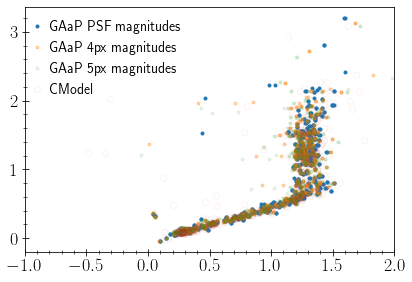

In [84]:
fig, ax = plt.subplots()

ax.plot(gPsfMag-rPsfMag, rPsfMag-iPsfMag, '.', label='GAaP PSF magnitudes')
ax.plot(g4Mag-r4Mag, r4Mag-i4Mag, '.', alpha=0.3, label='GAaP 4px magnitudes')
ax.plot(g5Mag-r5Mag, r5Mag-i5Mag, '.', alpha=0.1, label='GAaP 5px magnitudes')

ax.plot(g_r_cmodel, r_i_cmodel, 'o', fillstyle='none', alpha=0.05, label='CModel')
ax.set_xlim([-1,2])
ax.legend(loc='best')